In [2]:
import pandas as pd
import numpy as np
from pandas.core import resample
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

tf.reset_default_graph()

pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)
pd.set_option('display.max_columns', 800)


def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

#    for i in range(len(dataset)-look_back-1):
    for i in range(len(dataset)-look_back+1):
        xset = []
        for j in range(dataset.shape[1]):
            a = dataset[i:(i+look_back), j]
            xset.append(a)
#        dataY.append(dataset[i + look_back, ])      
        dataX.append(xset)
    return np.array(dataX), np.array(dataY)

In [3]:
from keras.models import load_model

#model.reset_states()
model = load_model("model_EURUSD1H.h5")
#model = load_model("modelGBPJPY4H.h5")


import pickle
scaler = pickle.load(open('model_EURUSD1H.pkl', 'rb'))
#scaler = pickle.load(open('modelGBPJPY4H.pkl', 'rb'))

Using TensorFlow backend.


In [4]:
# 為替予測
input_bars_for_predicate = 12  #　この先何本分を予測するか。


input_output_columns = 5
look_back=7                # model の設定と同じに
#number_of_historydata = 40

column=[ 'Close','High','Low','Open','ADXadx','HighLowDiff','OpenRelativePosition','CloseRelativePosition']



filename = './csv/3CUR_IND/EU60.csv'

#ファイルを読み込む
df_csv = pd.read_csv(filename,
#                nrows=100000,
                usecols=['Date','Week',
                        'Open','High','Low','Close','Volume','Profit','HighLowDiff','OpenRelativePosition','CloseRelativePosition',
                        'RCIs','RCIm','RCIl','ADXdm','ADXdp','ADXadx','MACD','MACDsig'],
                dtype={ 'Date': str,
                        'Week':float,
                        'Open':float,'High':float,'Low':float,'Close':float,'Volume':float,'Profit':float,
                        'HighLowDiff':float,'OpenRelativePosition':float,'CloseRelativePosition':float,
                        'RCIs':float,'RCIm':float,'RCIl':float,'ADXdm':float,'ADXdp':float,'ADXadx':float,'MACD':float,'MACDsig':float},
                parse_dates=[0]
            ).sort_values(by='Date', ascending=True)

In [5]:
df_csv.index = df_csv['Date']
df = df_csv[df_csv.index.year>=2018]
df.sort_index(ascending=True)

df.dropna(inplace=True) #2つ以上のNanは削除。inplaceは自身を書き換え

/usr/local/Cellar/python3/3.6.4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [6]:
dataframe = df.loc[:,column].dropna()
#dataframe = dataframe[-number_of_historydata:] # 最後の方のデータを使う

In [7]:
# predict 用データをコピーし、float64へ。同じエリアへ scaler-fitする
dataset = dataframe.values
dataset = dataset.astype('float64')
dataset = scaler.transform(dataset)
dataset.shape

(2918, 8)

In [8]:
print(dataframe[-5:])


                       Close     High      Low     Open     ADXadx  HighLowDiff  OpenRelativePosition  CloseRelativePosition
Date                                                                                                                        
2018-07-18 05:00:00  1.16544  1.16615  1.16537  1.16559  48.697431      0.00078             -0.435897              -0.820513
2018-07-18 06:00:00  1.16510  1.16558  1.16508  1.16544  48.355395      0.00050              0.440000              -0.920000
2018-07-18 07:00:00  1.16406  1.16511  1.16403  1.16510  50.134901      0.00108              0.981481              -0.944444
2018-07-18 08:00:00  1.16342  1.16445  1.16310  1.16409  52.653183      0.00135              0.466667              -0.525926
2018-07-18 09:00:00  1.16313  1.16374  1.16243  1.16345  55.416845      0.00131              0.557252               0.068702


In [9]:
dataset.shape

(2918, 8)

In [10]:
# LEVEL12 では使わない 
# HighLowDiff,OpenRelativePosition,CloseRelativePosition を再計算
#result_predicate_scaled[-1,5]=result_predicate_scaled[-1,1]-result_predicate_scaled[-1,2]
#result_predicate_scaled[-1,6]=((2*(result_predicate_scaled[-1,0]))-result_predicate_scaled[-1,1]-result_predicate_scaled[-1,2])/(result_predicate_scaled[-1,1]-(result_predicate_scaled[-1,2]))
#result_predicate_scaled[-1,7]=((2*(result_predicate_scaled[-1,3]))-result_predicate_scaled[-1,1]-result_predicate_scaled[-1,2])/(result_predicate_scaled[-1,1]-(result_predicate_scaled[-1,2]))
#print(result_predicate_scaled[-1:])

------ 過去36件 ------
(36, 8)
0
1
2
3
4
5
6
7


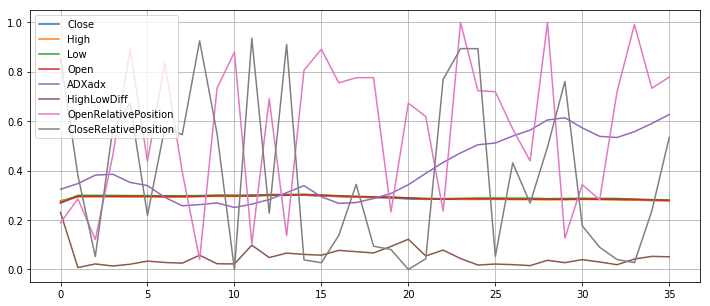

------ 過去の36件中の最後の13件目を抽出＝これをpredict予測に使う datasetは既に標準値化済み dataset_input ------
(24, 8)


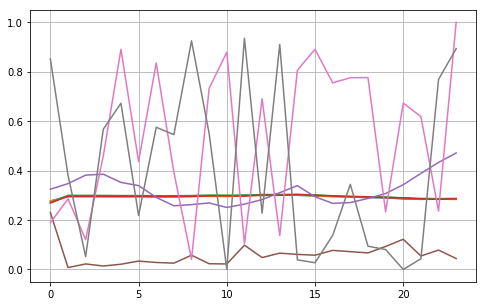

---- 予測値保存用配列を準備
(0, 5)


In [12]:

from pylab import rcParams


print('------ 過去36件 ------')
print(dataset[input_bars_for_predicate*-3:,].shape)

rcParams['figure.figsize'] = 12,5

for index, value in enumerate(column):
    plt.plot(dataset[input_bars_for_predicate*-3:,index], label=value)
plt.grid()
plt.legend()
plt.show()

print('------ 過去の36件中の最後の13件目を抽出＝これをpredict予測に使う datasetは既に標準値化済み dataset_input ------')
dataset_input = dataset[input_bars_for_predicate*-3:input_bars_for_predicate*-1:,]
print(dataset_input.shape)

rcParams['figure.figsize'] = 8,5
plt.grid()
plt.plot(dataset_input)
plt.show()

print('---- 予測値保存用配列を準備')
future_result = np.empty((0,len(dataset_input[0])-3))
print(future_result.shape)



In [13]:
for i in range(0,input_bars_for_predicate):

    dataset_tmp,dataset_nouse = create_dataset(dataset_input,look_back)
    print(dataset_tmp.shape)
    dataset_tmp = dataset_tmp[-1]
#    dataset_tmp = dataset_tmp.reshape(1,look_back,len(dataset_tmp))
    dataset_tmp = dataset_tmp.reshape(1,len(dataset_tmp),look_back)



    predict_tmp = model.predict(dataset_tmp) #,batch_size=1,steps=None)
    
    print('')
    print('------ 予測のために与える値(標準値化後) ------')
    print(dataset_tmp.shape)
    print(dataset_tmp[-5:,0])

    print('------ 予測値(標準値) ------')
    print(predict_tmp.shape)
    print(predict_tmp[-5:,0])
    result_for_scale = np.hstack([predict_tmp, np.zeros([predict_tmp.shape[0],len(dataset_input[0])-input_output_columns ])]) #右へN列0追加
    print(result_for_scale.shape)

    # 予測値をデータとしていれられるよう、足らない右Ｎ（3列）を作る。 0列目と同じ値（行は同じ数字になるはず）
    #result_for_scale[-1,4] = result_for_scale[-1,0] 
    #result_for_scale[-1,5] = result_for_scale[-1,0] 
    #result_for_scale[-1,6] = result_for_scale[-1,0] 
  
    # 'Close','High','Low','Open',
    #  Thanh Memo: 
    result_for_scale[-1,4]=result_for_scale[-1,1]-result_for_scale[-1,2]
    result_for_scale[-1,5]=((2*(result_for_scale[-1,3]))-result_for_scale[-1,1]-result_for_scale[-1,2])/(result_for_scale[-1,1]-(result_for_scale[-1,2]))
    result_for_scale[-1,6]=((2*(result_for_scale[-1,0]))-result_for_scale[-1,1]-result_for_scale[-1,2])/(result_for_scale[-1,1]-(result_for_scale[-1,2]))


    # 次の予測のための準備：先頭を消し
#    dataset_input = np.delete(dataset_input,0,axis=0)
    # 次の予測のための準備：末尾に予測値をセット
    
    print(future_result.shape)
    print(predict_tmp.shape)
    
    dataset_input = np.vstack((dataset_input,result_for_scale[-1,]))

    future_result= np.vstack((future_result,predict_tmp))





(18, 8, 7)

------ 予測のために与える値(標準値化後) ------
(1, 8, 7)
[[ 0.29305334  0.29056224  0.28975373  0.28531783  0.28354784  0.28586413
   0.28564561]]
------ 予測値(標準値) ------
(1, 5)
[ 0.28394651]
(1, 8)
(0, 5)
(1, 5)
(19, 8, 7)

------ 予測のために与える値(標準値化後) ------
(1, 8, 7)
[[ 0.29056224  0.28975373  0.28531783  0.28354784  0.28586413  0.28564561
   0.28394651]]
------ 予測値(標準値) ------
(1, 5)
[ 0.21808535]
(1, 8)
(1, 5)
(1, 5)
(20, 8, 7)

------ 予測のために与える値(標準値化後) ------
(1, 8, 7)
[[ 0.28975373  0.28531783  0.28354784  0.28586413  0.28564561  0.28394651
   0.21808535]]
------ 予測値(標準値) ------
(1, 5)
[ 0.2077021]
(1, 8)
(2, 5)
(1, 5)
(21, 8, 7)

------ 予測のために与える値(標準値化後) ------
(1, 8, 7)
[[ 0.28531783  0.28354784  0.28586413  0.28564561  0.28394651  0.21808535
   0.2077021 ]]
------ 予測値(標準値) ------
(1, 5)
[ 0.19071969]
(1, 8)
(3, 5)
(1, 5)
(22, 8, 7)

------ 予測のために与える値(標準値化後) ------
(1, 8, 7)
[[ 0.28354784  0.28586413  0.28564561  0.28394651  0.21808535  0.2077021
   0.19071969]]
------ 予測値(標準値) ------

In [14]:
# plot用に過去データ＋予測値（20本）を追加して　invert    

# 過去データ３倍分取得(input_bars_for_predicate(12)×3＝36本 24本を過去データ 12本を 過去データ＋予測データでプロット)
base_data = dataset[input_bars_for_predicate*-3:input_bars_for_predicate*-1:]
print(base_data.shape)
last_result_scale = dataset_input[input_bars_for_predicate*-1:,] 

concat_dataset = np.vstack((base_data,last_result_scale))
last_result =concat_dataset # scaler.inverse_transform(concat_dataset)



(24, 8)


dataset 過去のNbar=-36


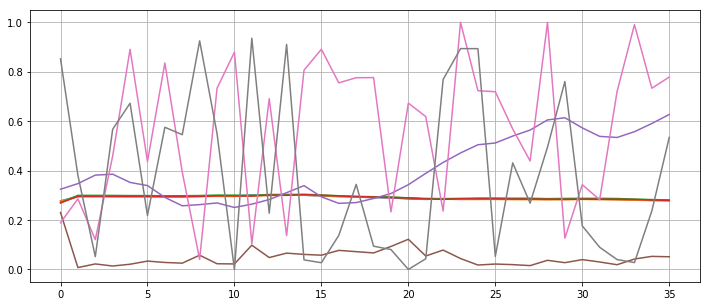

予測値直前 = dataset 過去のNbar=-36〜-12


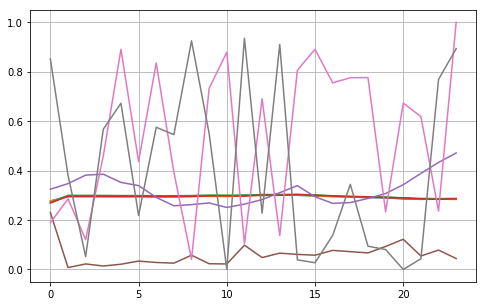

 予測値 = last_result_scale


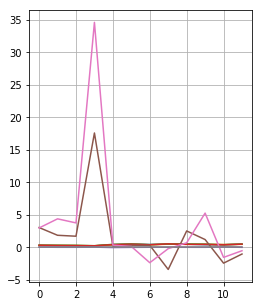

 全体連結 


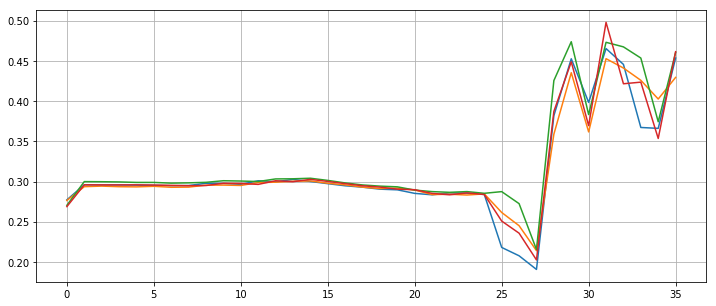

 全体連結 -- 実際の値化


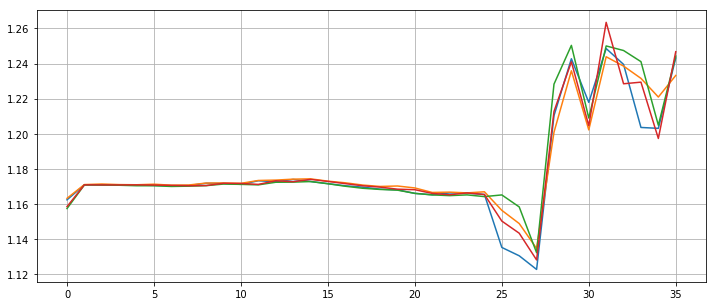

 全体連結 -- 本来のデータ


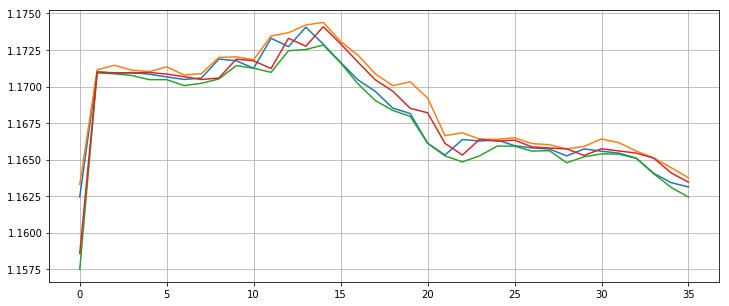

In [15]:

# plot用に過去データ-(36〜-12）＋予測値(12)   
#last_data_scale =  dataset[input_bars_for_predicate*-3:input_bars_for_predicate*-1:,]
#last_result_scale =  dataset_input[input_bars_for_predicate*-1+0:,]
#concat_dataset = np.vstack((last_data_scale,last_result_scale))
#last_result = scaler.inverse_transform(concat_dataset)

print('dataset 過去のNbar=' + str(-input_bars_for_predicate*3))
rcParams['figure.figsize'] = 12,5
plt.plot(dataset[-input_bars_for_predicate*3:]) #,[0,1,2,3]])
plt.grid()
plt.show()

print('予測値直前 = dataset 過去のNbar=' + str(-input_bars_for_predicate*3) + '〜' + str(-input_bars_for_predicate*1))
rcParams['figure.figsize'] = 8,5
plt.plot(base_data[:,]) #[0,1,2,3]])
plt.grid()
plt.show()

print(' 予測値 = last_result_scale')
rcParams['figure.figsize'] = 4,5
plt.plot(last_result_scale[input_bars_for_predicate*-1:,]) #[0,1,2,3]])
#plt.plot(dataset_input[input_bars_for_predicate*-1+0:,[0,1,2,3]])
plt.grid()
plt.show()

print(' 全体連結 ')
rcParams['figure.figsize'] = 12,5
plt.plot(last_result[:,[0,1,2,3]])
plt.grid()
plt.show()

print(' 全体連結 -- 実際の値化')
last_result_real =scaler.inverse_transform(last_result)
rcParams['figure.figsize'] = 12,5
plt.plot(last_result_real[:,[0,1,2,3]])
plt.grid()
plt.show()

print(' 全体連結 -- 本来のデータ')
result_real =scaler.inverse_transform(dataset[input_bars_for_predicate*-3::,])
rcParams['figure.figsize'] = 12,5
plt.plot(result_real[:,[0,1,2,3]])
plt.grid()
plt.show()


In [14]:
a=[1,2,3,4,5,6,7,8,9,10]
print(a)
print(a[2])
print(a[2::]) #offset2からすべて
print(a[:2:]) #先頭から2件
print(a[::2]) #一個飛ばし
print(a[-2:]) #最後の数件
print(a[-4:-2:])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
3
[3, 4, 5, 6, 7, 8, 9, 10]
[1, 2]
[1, 3, 5, 7, 9]
[9, 10]
[7, 8]
